# Difference in differences

In [1]:
# Install and load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wbgapi as wb
from math import log
from linearmodels import PanelOLS
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
import pandas as pd
import statsmodels.formula.api as sm
import numpy as np
import patsy
from linearmodels.panel import PanelOLS as fe

## 1

In [2]:
data = pd.read_stata("https://github.com/worldbank/r-econ-visual-library/raw/master/Library/Data/evaluation.dta")

data["enrolled"] = data["enrolled"].astype("category")
data["enrolled"] = data["enrolled"].cat.rename_categories(["Control","Treatment"])


In [3]:
data2= (data
       .groupby(['enrolled', 'round'])
       .agg({'enrolled':'first', 'round':'first',
             'health_expenditures': ['mean', 'std']
            }))


data2.columns = ["_".join(x) for x in data2.columns]

data2=data2.reset_index(drop=True)

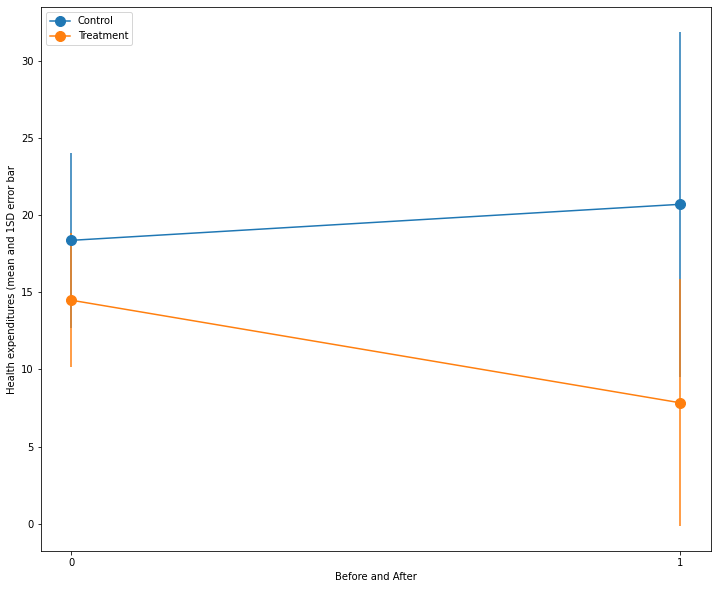

In [4]:
dfp = data2.pivot(index='round_first', columns='enrolled_first', values='health_expenditures_mean')
yerr = data2.pivot(index='round_first', columns='enrolled_first', values='health_expenditures_std')


dfp.plot(
    figsize=(12, 10),
    marker='.', 
    markersize=20, 
    title='',
    xlabel='Before and After',
    ylabel='Health expenditures (mean and 1SD error bar',
    yerr = yerr,
    xticks=data2['round_first'].drop_duplicates().sort_values().astype('int'))

plt.legend(loc="upper left")



## 2

In [5]:
data = pd.read_stata("https://github.com/worldbank/r-econ-visual-library/raw/master/Library/Data/autor-jole-2003.dta")


In [6]:
data2 = data[data['year'] >= 79.0]
data3 = data2[data2['year'] <= 95.0]
data4 = data3[data3['state'] != 98.0]


In [7]:
data4['year'] = pd.to_numeric(data4['year'])
data4["trend"] = data4["year"]-78

data4["state_trend"] = data4["state"]/data4["trend"]
data4['annemp'] = pd.to_numeric(data4['annemp'])
data4["state_year"] = [(s,y) for s,y in zip(data4.state, data4.year)]

In [8]:
data5 = data4[['state', 'year','state_year', 'state_trend','annemp', 'lnths','admico_2', 'admico_1', 'admico0', 'admico1', 'admico2', 'admico3', 'mico4', 'admppa_2', 'admppa_1', 'admppa0', 'admppa1', 'admppa2', 'admppa3', 'mppa4','admgfa_2','admgfa_1', 'admgfa0','admgfa1', 'admgfa2','admgfa3', 'mgfa4', 'trend']]
data5_reset=data5.set_index(['state_year', 'state_trend'])

formula = 'lnths ~ np.log10(data5_reset.annemp) + admico_2 + admico_1 + admico0 + admico1 + admico2 + admico3 + mico4 + admppa_2 + admppa_1 + admppa0 + admppa1 + admppa2 + admppa3 + mppa4 + admgfa_2 + admgfa_1 + admgfa0 + admgfa1 + admgfa2 + admgfa3 + mgfa4 - 1'
y, x_data = patsy.dmatrices(formula, data5_reset, return_type = 'dataframe')

fixed = fe(y, exog = x_data, entity_effects = True, time_effects = True, drop_absorbed=True).fit(cov_type = 'clustered', cluster_entity = True)
print(fixed)


/var/folders/t0/bh8jstj91y5ctmcqzzd24zyc0000gn/T/ipykernel_19807/3613437251.py:7: MemoryWarning: Using low-memory algorithm to estimate two-way model. Explicitly set low_memory=True to silence this message.  Set low_memory=False to use the standard algorithm that creates dummy variables for the smaller of the number of entities or number of time periods.
  fixed = fe(y, exog = x_data, entity_effects = True, time_effects = True, drop_absorbed=True).fit(cov_type = 'clustered', cluster_entity = True)


ValueError: All columns in exog have been fully absorbed by the included effects. This model cannot be estimated.